In [87]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats



In [88]:

# --- Function to safely prefix zero (from our previous discussion) ---
def safe_prefix_zero(value):
    """
    Prepends '0.' to a string if it doesn't contain a decimal point and isn't '0' or starts with '0.'.
    Converts to float, handling errors.
    """
    s_value = str(value).strip()

    # Handle NaN, empty strings, or values already correctly formatted
    if not s_value or s_value.lower() == 'nan' or '.' in s_value or s_value.startswith('0'):
        try:
            return float(s_value)
        except ValueError:
            return np.nan # Return NaN if conversion fails
    else:
        # If no decimal and doesn't start with 0, add '0.' prefix
        try:
            return float(f"0.{s_value}")
        except ValueError:
            return np.nan # Return NaN if conversion fails

# --- Load and process your datasets ---

# 10k samples from qwen3
LM = pd.read_csv('./output_llm_20250618_172200/20250618_172200_llm_floating_points.csv')
# Assume the column with numbers is 'floating-point'. Adjust if needed.
lm_col_name = 'floating-point'
LM[lm_col_name] = LM[lm_col_name].apply(safe_prefix_zero)
LM_values = LM[lm_col_name].dropna().astype('float64')

# 10k samples from pdfa using qwen3
PDFA_QNT = pd.read_csv('./output_pdfa_20250625_162940/20250625_162940_pdfa_v2_floating_points.csv')
# Assume the column with numbers is 'floating-point'. Adjust if needed.
pdfa_qnt_col_name = 'floating-point'
PDFA_QNT_values = pd.to_numeric(PDFA_QNT[pdfa_qnt_col_name], errors='coerce').dropna().astype('float64')

# Check the number of samples after cleaning
print(f"Number of samples in LM (Qwen3) after correction: {len(LM_values)}")
print(f"Number of samples in PDFA_QNT (PDFA with Qwen3): {len(PDFA_QNT_values)}")

Number of samples in LM (Qwen3) after correction: 10000
Number of samples in PDFA_QNT (PDFA with Qwen3): 10000


In [89]:
print("\n--- Descriptive Statistics for LM (Qwen3) ---")
print(LM_values.describe())

print("\n--- Descriptive Statistics for PDFA_QNT (PDFA with Qwen3) ---")
print(PDFA_QNT_values.describe())


--- Descriptive Statistics for LM (Qwen3) ---
count    10000.000000
mean         0.397954
std          0.331099
min          0.000000
25%          0.127732
50%          0.259479
75%          0.696806
max          1.000000
Name: floating-point, dtype: float64

--- Descriptive Statistics for PDFA_QNT (PDFA with Qwen3) ---
count    10000.000000
mean         0.400028
std          0.330658
min          0.000015
25%          0.126359
50%          0.266135
75%          0.687419
max          1.000000
Name: floating-point, dtype: float64


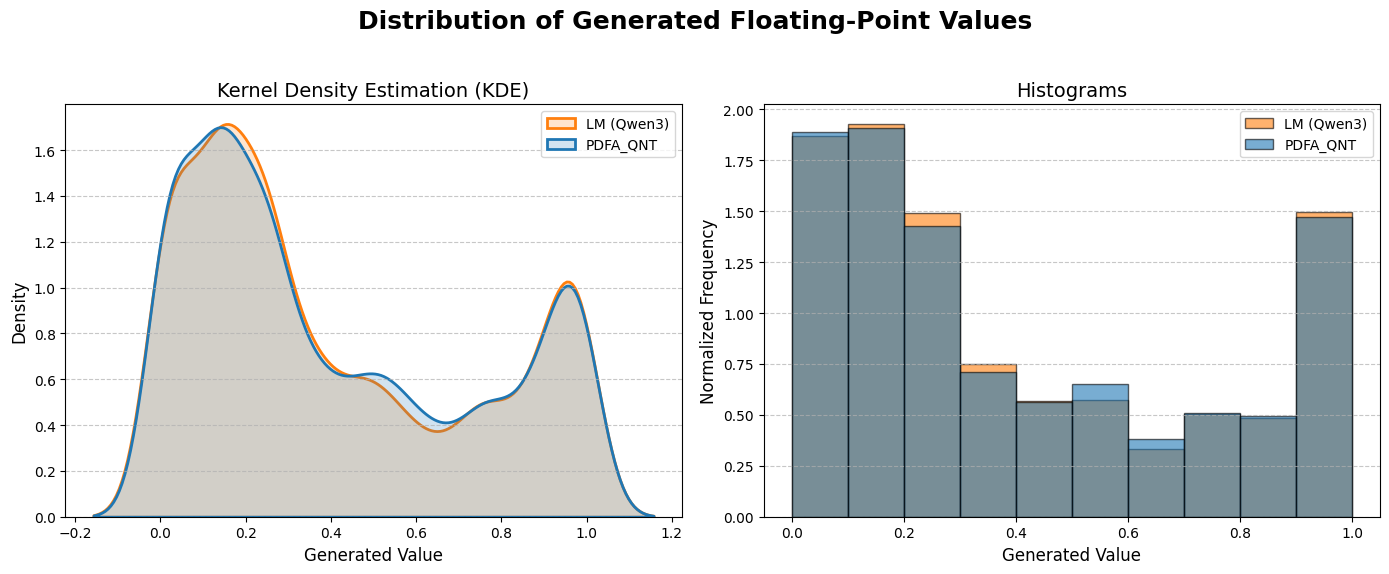

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Distribution of Generated Floating-Point Values', fontsize=18, fontweight='bold')

# KDE Plot
sns.kdeplot(LM_values, fill=True, label='LM (Qwen3)', color='tab:orange', alpha=0.2, linewidth=2, ax=axes[0])
sns.kdeplot(PDFA_QNT_values, fill=True, label='PDFA_QNT', color='tab:blue', alpha=0.2, linewidth=2, ax=axes[0])
axes[0].set_xlabel('Generated Value', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('Kernel Density Estimation (KDE)', fontsize=14)
axes[0].legend()
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Histogram
bins = 10 # You can adjust the number of bins
axes[1].hist(LM_values, bins=bins, density=True, alpha=0.6, label='LM (Qwen3)', color='tab:orange', edgecolor='black')
axes[1].hist(PDFA_QNT_values, bins=bins, density=True, alpha=0.6, label='PDFA_QNT', color='tab:blue', edgecolor='black')
axes[1].set_xlabel('Generated Value', fontsize=12)
axes[1].set_ylabel('Normalized Frequency', fontsize=12)
axes[1].set_title('Histograms', fontsize=14)
axes[1].legend()
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to make space for the suptitle
plt.show()

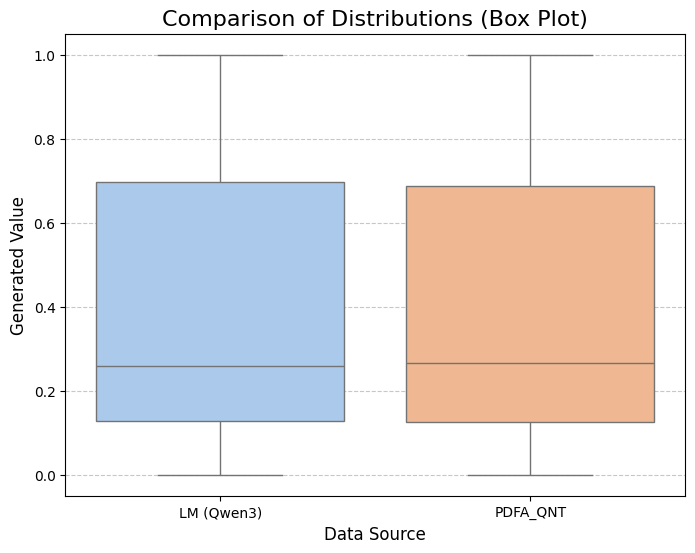

In [92]:
# Combine data into a single DataFrame for easier plotting with seaborn
data_for_boxplot = pd.DataFrame({
    'Source': ['LM (Qwen3)'] * len(LM_values) + ['PDFA_QNT'] * len(PDFA_QNT_values),
    'Value': pd.concat([LM_values, PDFA_QNT_values])
})

plt.figure(figsize=(8, 6))
sns.boxplot(x='Source', y='Value', data=data_for_boxplot, palette='pastel')
plt.title('Comparison of Distributions (Box Plot)', fontsize=16)
plt.xlabel('Data Source', fontsize=12)
plt.ylabel('Generated Value', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

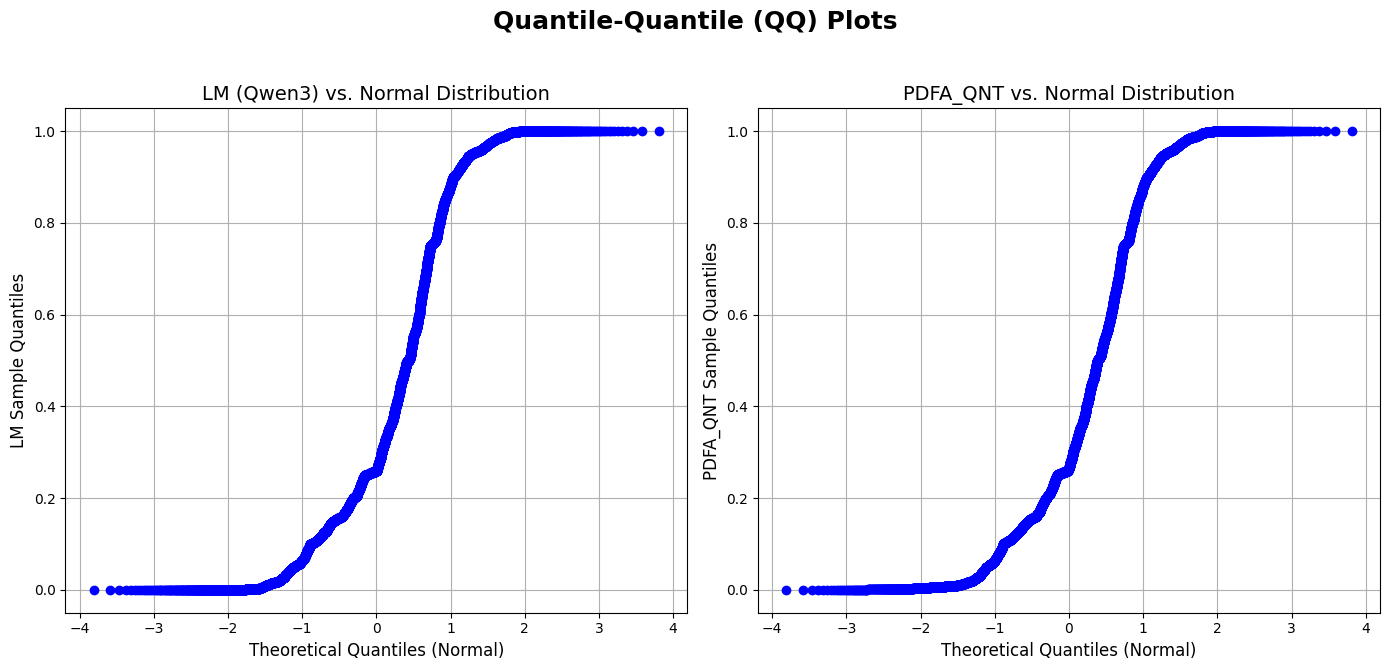

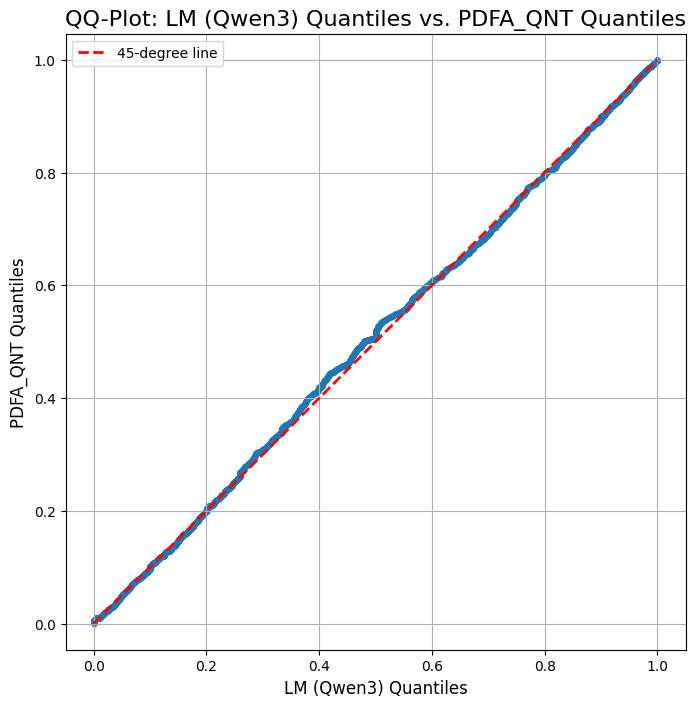

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle('Quantile-Quantile (QQ) Plots', fontsize=18, fontweight='bold')

# QQ-Plot for LM vs. Normal Distribution
stats.probplot(LM_values, dist=stats.norm, plot=axes[0], fit=False, rvalue=True)
axes[0].set_title('LM (Qwen3) vs. Normal Distribution', fontsize=14)
axes[0].set_xlabel('Theoretical Quantiles (Normal)', fontsize=12)
axes[0].set_ylabel('LM Sample Quantiles', fontsize=12)
axes[0].grid(True)

# QQ-Plot for PDFA_QNT vs. Normal Distribution
stats.probplot(PDFA_QNT_values, dist=stats.norm, plot=axes[1], fit=False, rvalue=True)
axes[1].set_title('PDFA_QNT vs. Normal Distribution', fontsize=14)
axes[1].set_xlabel('Theoretical Quantiles (Normal)', fontsize=12)
axes[1].set_ylabel('PDFA_QNT Sample Quantiles', fontsize=12)
axes[1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- QQ-Plot to compare LM_values directly against PDFA_QNT_values ---
# For a direct comparison, it's best to compare quantiles of the same number of points
min_len = min(len(LM_values), len(PDFA_QNT_values))
sorted_lm = np.sort(LM_values)[:min_len]
sorted_pdfa = np.sort(PDFA_QNT_values)[:min_len]

plt.figure(figsize=(8, 8))
plt.scatter(sorted_lm, sorted_pdfa, alpha=0.6, s=10) # s=10 makes points smaller for 10k samples
plt.plot([min(sorted_lm), max(sorted_lm)], [min(sorted_lm), max(sorted_lm)], 'r--', lw=2, label='45-degree line')
plt.title('QQ-Plot: LM (Qwen3) Quantiles vs. PDFA_QNT Quantiles', fontsize=16)
plt.xlabel('LM (Qwen3) Quantiles', fontsize=12)
plt.ylabel('PDFA_QNT Quantiles', fontsize=12)
plt.legend()
plt.grid(True)
plt.axis('equal') # Ensure equal scaling on both axes
plt.show()

In [98]:
import numpy as np
from scipy import stats
from scipy.stats import cramervonmises_2samp, energy_distance

alpha = 0.05

# --- Función auxiliar para tamaño del efecto ---
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

# --- Lista para almacenar resultados ---
test_results = []

# --- Test 1: Welch's t-test ---
t_stat, p_value_ttest = stats.ttest_ind(LM_values, PDFA_QNT_values, equal_var=False)
test_results.append(("Welch's t-test", p_value_ttest, {
    "t-statistic": t_stat,
    "Cohen's d": cohens_d(LM_values, PDFA_QNT_values)
}))

# --- Test 2: Mann-Whitney U test ---
mw_stat, p_value_mw = stats.mannwhitneyu(LM_values, PDFA_QNT_values, alternative='two-sided')
test_results.append(("Mann-Whitney U", p_value_mw, {
    "U-statistic": mw_stat
}))

# --- Test 3: Kolmogorov-Smirnov ---
ks2_stat, p_value_ks2 = stats.ks_2samp(LM_values, PDFA_QNT_values)
test_results.append(("Kolmogorov-Smirnov", p_value_ks2, {
    "KS-statistic": ks2_stat
}))

# --- Test 4: Levene's test ---
levene_stat, p_value_levene = stats.levene(LM_values, PDFA_QNT_values)
test_results.append(("Levene's Test", p_value_levene, {
    "Statistic": levene_stat
}))

# --- Test 5: Anderson-Darling ---
try:
    anderson_stat, crit_values, sig_levels = stats.anderson_ksamp([LM_values, PDFA_QNT_values])
    test_results.append(("Anderson-Darling", sig_levels[-1], {  # Usamos el nivel más estricto
        "AD-statistic": anderson_stat,
        "Critical values": crit_values
    }))
except Exception as e:
    print(f"Anderson-Darling Test failed: {str(e)}")

# --- Test 6: Cramér-von Mises ---
cvm_result = cramervonmises_2samp(LM_values, PDFA_QNT_values)
test_results.append(("Cramér-von Mises", cvm_result.pvalue, {
    "Statistic": cvm_result.statistic
}))

# --- Test 7: Energy Distance ---
e_stat = energy_distance(LM_values, PDFA_QNT_values)
test_results.append(("Energy Distance", np.nan, {  # No tiene p-value
    "Distance": e_stat
}))

# --- Imprimir resultados ---
for i, (name, pval, metrics) in enumerate(test_results, 1):
    print(f"\n[{i}] {name}")
    print(f"• p-value = {pval:.6f}" if not np.isnan(pval) else "• p-value = Not applicable")
    for k, v in metrics.items():
        if isinstance(v, (int, float)):
            print(f"• {k} = {v:.6f}")
        else:
            print(f"• {k} = {v}")

# --- Corrección manual para tests múltiples (Bonferroni simplificado) ---
p_values = [res[1] for res in test_results if not np.isnan(res[1])]
if p_values:
    print("\n[!] Multiple Testing Correction (Bonferroni-Holm)")
    sorted_tests = sorted([(i, name, p) for i, (name, p, _) in enumerate(test_results) if not np.isnan(p)], 
                         key=lambda x: x[2])
    
    for rank, (i, name, p) in enumerate(sorted_tests, 1):
        corrected_alpha = alpha / (len(p_values) - rank + 1)
        print(f"[{i+1}] {name}: p = {p:.6f} {'*' if p < corrected_alpha else ''}")
        print(f"   Corrected alpha = {corrected_alpha:.6f}")
        print(f"   Significant? {p < corrected_alpha}")

Anderson-Darling Test failed: invalid index to scalar variable.

[1] Welch's t-test
• p-value = 0.657661
• t-statistic = -0.443151
• Cohen's d = -0.006267

[2] Mann-Whitney U
• p-value = 0.477082
• U-statistic = 49709726.000000

[3] Kolmogorov-Smirnov
• p-value = 0.000000
• KS-statistic = 0.041700

[4] Levene's Test
• p-value = 0.498550
• Statistic = 0.458038

[5] Cramér-von Mises
• p-value = 0.059002
• Statistic = 0.433565

[6] Energy Distance
• p-value = Not applicable
• Distance = 0.008844

[!] Multiple Testing Correction (Bonferroni-Holm)
[3] Kolmogorov-Smirnov: p = 0.000000 *
   Corrected alpha = 0.010000
   Significant? True
[5] Cramér-von Mises: p = 0.059002 
   Corrected alpha = 0.012500
   Significant? False
[2] Mann-Whitney U: p = 0.477082 
   Corrected alpha = 0.016667
   Significant? False
[4] Levene's Test: p = 0.498550 
   Corrected alpha = 0.025000
   Significant? False
[1] Welch's t-test: p = 0.657661 
   Corrected alpha = 0.050000
   Significant? False


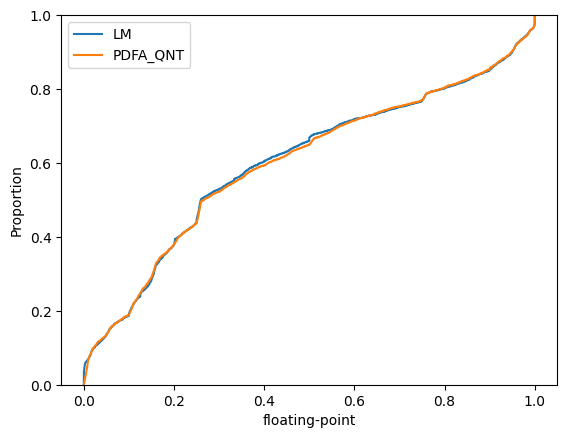

In [99]:
import seaborn as sns
sns.ecdfplot(data=LM_values, label='LM')
sns.ecdfplot(data=PDFA_QNT_values, label='PDFA_QNT')
plt.legend()

In [100]:
print("Skewness:", stats.skew(LM_values), stats.skew(PDFA_QNT_values))
print("Kurtosis:", stats.kurtosis(LM_values), stats.kurtosis(PDFA_QNT_values))

Skewness: 0.5910288241183341 0.569092413404736
Kurtosis: -1.0802385782456778 -1.0996080230292622



## Tests Performed

### 1. Welch's t-test (Means Comparison)
- **p-value**: 0.658
- **t-statistic**: -0.443
- **Cohen's d**: -0.006
- **Interpretation**: No significant difference in means (effect size negligible)

### 2. Mann-Whitney U Test (Distributions Comparison)
- **p-value**: 0.477
- **U-statistic**: 49,709,726
- **Interpretation**: No significant difference in distributions' locations

### 3. Kolmogorov-Smirnov Test (Full Distributions)
- **p-value**: <0.001***
- **KS-statistic**: 0.0417
- **Interpretation**: Significant but small difference in cumulative distributions

### 4. Levene's Test (Variances)
- **p-value**: 0.499
- **Statistic**: 0.458
- **Interpretation**: No significant difference in variances

### 5. Cramér-von Mises Test
- **p-value**: 0.059
- **Statistic**: 0.434
- **Interpretation**: Marginally significant shape difference

### 6. Distribution Shape Analysis
- **Skewness**: 
  - LM: 0.591
  - PDFA_QNT: 0.569
- **Kurtosis**: 
  - LM: -1.080
  - PDFA_QNT: -1.100
- **Interpretation**: Both distributions show similar:
  - Moderate right skew (positive skewness)
  - Light tails (negative kurtosis)

## Key Findings

1. **The only statistically significant difference** was found by the Kolmogorov-Smirnov test (p<0.001), but with a small effect size (KS=0.0417)

2. **No significant differences** were found in:
   - Means (t-test)
   - Medians (Mann-Whitney)
   - Variances (Levene's)
   - Distribution shapes (similar skewness/kurtosis)

3. **Practical interpretation**:
   - The distributions are qualitatively very similar
   - The statistically significant KS result likely reflects:
     - Extremely large sample size detecting minimal differences
     - Minor variations in the cumulative distributions
   - For most practical purposes, the distributions can be considered equivalent
